In [10]:
import pyspark
from pyspark import SparkContext
import numpy as np
from operator import add
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

In [2]:
sc = SparkContext()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/12 18:51:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
spark = SparkSession\
  .builder \
  .appName("PythonWordCount") \
  .getOrCreate()

In [5]:
csv_10 = os.listdir('./csv_10/')
csv_10.remove('.ipynb_checkpoints')
csv_10

['bbc_news.csv',
 'Booking_Jobs_All_220218.csv',
 'Booking_Jobs_All_220227.csv',
 'amazonFood.csv',
 'F1_Driver_Standings.csv',
 'F1_Race_Results.csv',
 'move.csv',
 'F1_Constructor_Standings.csv',
 'DatingAppReviewsDataset.csv',
 'Booking_Jobs_All_220312.csv']

In [6]:
target_columns = ['description', 'Job Description', 'Job Description', 'Text', 'Nationality', 'Grand Prix', 'metro', 'Team', 'Review', 'Job Description']

In [32]:
most_popular_10_words = []

for indx, file in enumerate(csv_10):
    print(file)
    data = spark.read.format('csv').options(header='true', inferSchema='true').load(f'./csv_10/{file}')
    data = data.dropna()
    
    tokenizer = Tokenizer(inputCol=target_columns[indx], outputCol="words_token")
    tokenized = tokenizer.transform(data).select('words_token')
    
    remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
    data_clean = remover.transform(tokenized).select( 'words_clean')
    
    result = data_clean.withColumn('word', f.explode(f.col('words_clean'))).groupBy('word').count().sort('count', ascending=False)
    
    result = result.toPandas()
    
    if result[:2].word[0] in ['●', '🫤', '•','', ' ', '/><br']:
        most_popular_10_words.append((file, result[:2].word[1], result[:2]['count'][1]))
    else:
        most_popular_10_words.append((file, result[:2].word[0], result[:2]['count'][0]))
    
    result.to_csv(f'./csv_res/{file}', index=False)

bbc_news.csv
Booking_Jobs_All_220218.csv
Booking_Jobs_All_220227.csv
amazonFood.csv


F1_Driver_Standings.csv
F1_Race_Results.csv
move.csv
F1_Constructor_Standings.csv
DatingAppReviewsDataset.csv


Booking_Jobs_All_220312.csv


In [33]:
csv_res = os.listdir('./csv_res/')
csv_res.remove('.ipynb_checkpoints')

print(len(csv_res))
print(csv_res)

10
['bbc_news.csv', 'Booking_Jobs_All_220218.csv', 'Booking_Jobs_All_220227.csv', 'amazonFood.csv', 'F1_Driver_Standings.csv', 'F1_Race_Results.csv', 'move.csv', 'F1_Constructor_Standings.csv', 'DatingAppReviewsDataset.csv', 'Booking_Jobs_All_220312.csv']


In [34]:
popular_10_words = []
for i, j, k in most_popular_10_words:
    popular_10_words.append([j, k])
    print(i, ': ', j, ' ', k)

bbc_news.csv :  russian   39
Booking_Jobs_All_220218.csv :  colour   248
Booking_Jobs_All_220227.csv :  religion   272
amazonFood.csv :  like   15688
F1_Driver_Standings.csv :  gbr   289
F1_Race_Results.csv :  great   72
move.csv :  planernaia   126
F1_Constructor_Standings.csv :  ford   173
DatingAppReviewsDataset.csv :  app   173577
Booking_Jobs_All_220312.csv :  religion   270


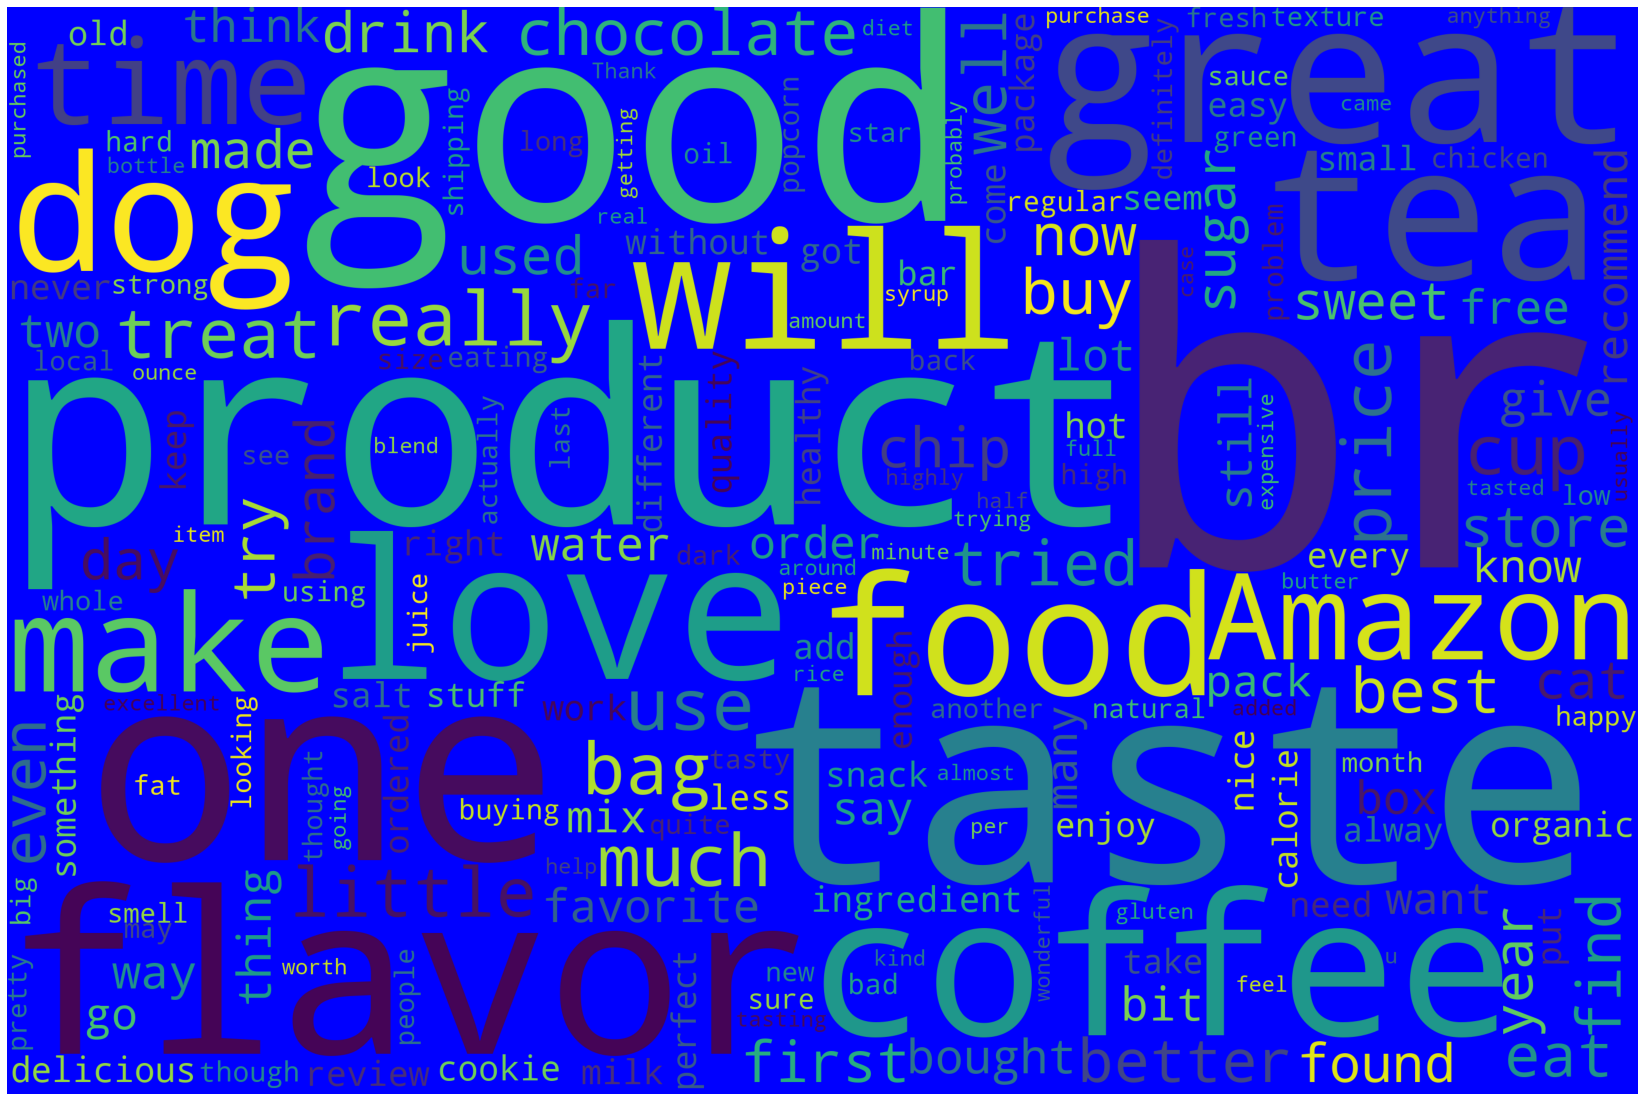

In [16]:
amazone = pd.read_csv('./csv_10/amazonFood.csv', sep=',')
text = amazone.Text.to_json()
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(30, 20))

plt.imshow(wordcloud) 

plt.axis("off")
plt.show()

In [35]:
amazone = pd.read_csv('./csv_res/amazonFood.csv', sep=',')
amazone = amazone.dropna()

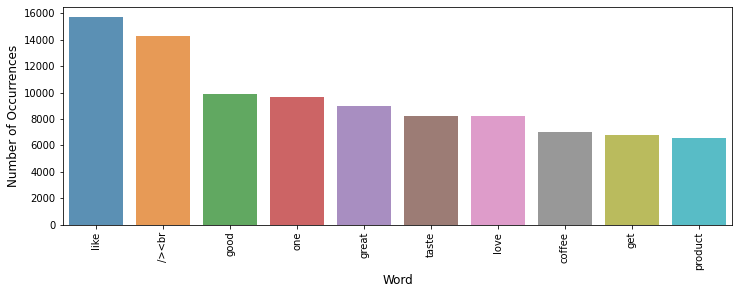

In [36]:
plt.figure(figsize=(12,4))
sns.barplot(data=amazone[:10], x='word', y='count', alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.show()

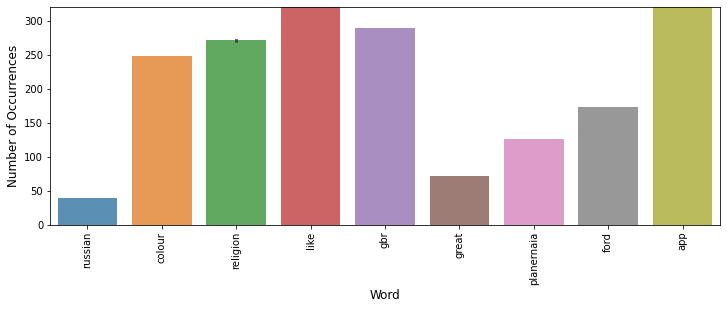

In [42]:
df = pd.DataFrame(popular_10_words, columns =['word', 'count'])


plt.figure(figsize=(12,4))
sns.barplot(data=df, x='word', y='count', alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.ylim(0, 320)
plt.show()